|평가문항|	상세기준|
|:-|:-|
|1. 주어진 함수들과 TensorFlow Data API를 이용해서 dataloader를 구현했다|	dataloader를 만드는 과정이 에러 없이 수행되었다|
|2. 베트남 음식 사진 분류를 위한 모델을 구현했다.|	EfficientNetB0 backbone과 Dense 레이어를 결합하여 모델을 성공적으로 구현했다|
|3. TensorFlow GradientTape을 이용해서 custom trainer 클래스를 구현했다|	학습이 진행되면서 training accuracy가 점차 증가하였다|

# 프로젝트: 베트남 음식 분류하기
지금까지 잘 따라오셨나요? 무탈하게 따라오셨길 바랍니다!
이제는 직접 Classification을 해보는 과정을 진행해보기로 합시다.

여러분 베트남 음식 좋아하시나요? 이번에 사용할 데이터는 30VNFoods라는 데이터로 30가지 베트남 음식 이미지를 모아놓은 것입니다. 아래와 같이 Banh xeo, Pho 등 다양한 이미지들이 있습니다.
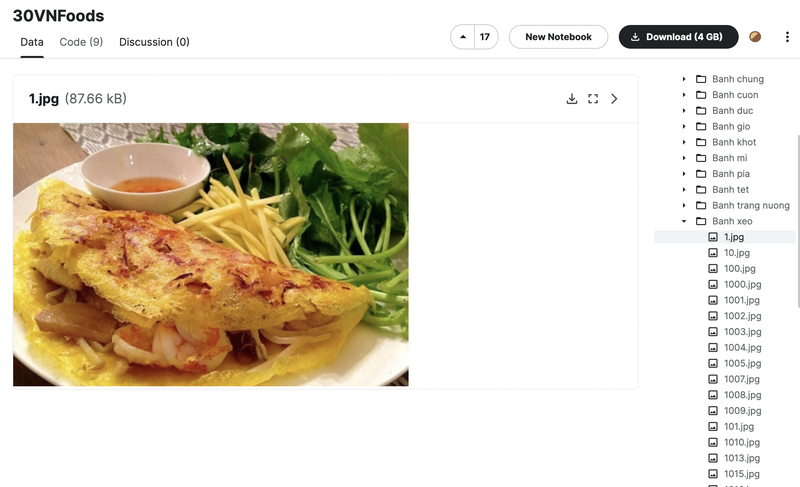
아래의 이미지 파일들을 확인해보시면 이 데이터셋에는 정제되지 않은 데이터가 많이 포함되어 있다는 것을 알 수 있습니다. 하나의 카테고리에 속한 이미지들 사이에서도 음식의 형태와 구성이 매우 다양하죠. 학습을 조금이라도 쉽게 하기 위해서, 여기에서는 30종류의 베트남 음식 중 10개의 카테고리를 선별해서 실습을 진행할 예정입니다.
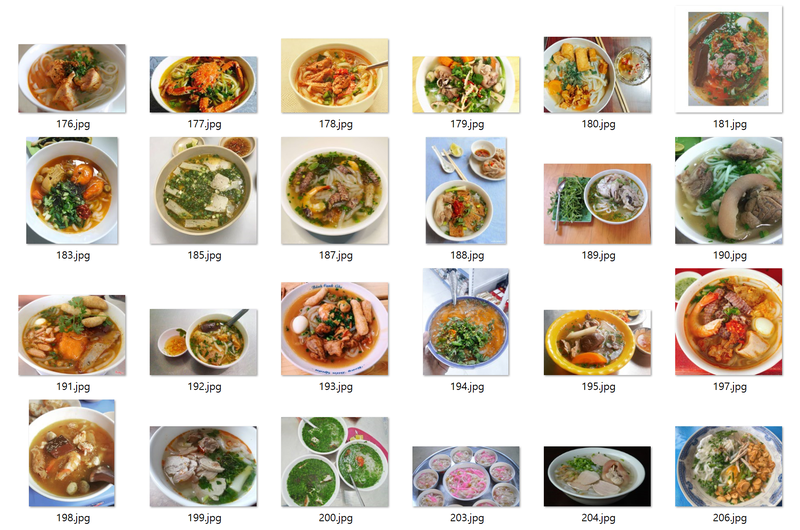

한 가지 기쁜 소식은 Train, validation, test 셋으로 이미 나눠져 있기 때문에 바로 데이터로더와 모델, 그리고 트레이너만 만들어서 학습 및 테스트를 해볼 수 있다는 것입니다.
원하는 방식대로 코드를 만들어 학습 및 테스트해보세요. 아래의 껍데기 코드를 채워넣어도 좋습니다!

In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

손상된 이미지 파일들을 삭제해줍니다. 이 작업은 2-3분 정도 걸립니다. 🙂






In [2]:
# training set과 test set의 모든 이미지 파일에 대해서,
# jpg image header가 포함되지 않은 (jpg의 파일 구조에 어긋나는) 파일들을 삭제해줍니다.

data_path = '/aiffel/aiffel/aiffel/model-fit/30vnfoods/'
train_path = data_path + 'Train/'
test_path = data_path + 'Test/'

for path in [train_path, test_path]:
    classes = os.listdir(path)

    for food in classes:
        food_path = os.path.join(path, food)
        images = os.listdir(food_path)
        
        for image in images:
            with open(os.path.join(food_path, image), 'rb') as f:
                bytes = f.read()
            if bytes[:3] != b'\xff\xd8\xff':
                print(os.path.join(food_path, image))
                os.remove(os.path.join(food_path, image))

In [3]:
classes = os.listdir(train_path)
train_length = 0

for food in classes:
    food_path = os.path.join(train_path, food)
    images = os.listdir(food_path)
    
    train_length += len(images)

print('training data의 개수: '+str(train_length))

training data의 개수: 9775


이제 여러분들이 직접 코드를 작성할 차례입니다. 우리가 해결할 문제는 3가지입니다.

- 문제1: dataloader 구현하기
    - 주어진 함수들과 TensorFlow Data API를 이용해서 dataloader를 구현해야 합니다.
- 문제2: 모델 구현하기
    - EfficientNetB0 backbone과 Dense 레이어를 결합하여 모델을 구현해야 합니다.
    - 다른 모델을 사용하여 backbone을 만들어 보아도 좋습니다.
- 문제3: custom trainer 구현하기
    - TensorFlow GradientTape를 이용해서 custom trainer 클래스를 구현해야 합니다.
    - 학습이 진행되면서 training accuracy가 점차 증가할 수 있도록 만들어 보세요.
    
이전에 배웠던 부분을 기억하면서 코드를 작성해 보세요.






In [4]:
# 문제1: dataloader 구현하기

def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로 부터 class label을 만들고, 이미지를 읽는 함수
    이미지 크기를 (224, 224)로 맞춰주세요.
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    
    return img, label

def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()  # Repeat the dataset indefinitely
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    TensorFlow Dataset 객체를 생성하고 process_path 함수로 이미지와 라벨을 묶은 다음,
    prepare_for_training 함수로 batch가 적용된 Dataset 객체를 만들어주세요.
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

In [5]:
# 문제2: 모델 구현하기

from tensorflow.keras.applications import EfficientNetB0

class Model(tf.keras.Model):
    '''
    EfficientNetB0을 백본으로 사용하는 모델을 구성합니다.
    Classification 문제로 접근할 것이기 때문에 맨 마지막 Dense 레이어에 
    우리가 원하는 클래스 개수만큼을 지정해주어야 합니다.
    '''
    def __init__(self, num_classes=10, freeze=False):
        super(Model, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        if freeze:
            self.base_model.trainable = False  # Freeze the base model if required

        # Sequential layer to add on top of the base model
        self.top = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),  # Pooling layer to reduce dimensionality
            tf.keras.layers.BatchNormalization(),  # Normalization layer
            tf.keras.layers.Dropout(0.5, name="top_dropout")  # Dropout layer to reduce overfitting
        ])
        
        # Output layer for classification
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")

    def call(self, inputs, training=True):
        x = self.base_model(inputs, training=training)  # Pass inputs through the base model
        x = self.top(x, training=training)  # Pass base model outputs through the sequential top layer
        x = self.classifier(x)  # Output layer for class prediction
        return x

In [6]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer, train_path):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.total_train_images = len([f for cls in os.listdir(train_path) for f in os.listdir(os.path.join(train_path, cls)) if f.endswith('.jpg')])
        self.steps_per_epoch = self.total_train_images // batch
        self.loss_history = []  # loss 기록을 위한 리스트
        self.accuracy_history = []  # accuracy 기록을 위한 리스트

    def train(self, train_dataset, train_metric):
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch + 1,))
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = self.model(x_batch_train, training=True)
                    loss_value = self.loss_fn(y_batch_train, logits)
                grads = tape.gradient(loss_value, self.model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
                train_metric.update_state(y_batch_train, logits)
                
                # 현재 배치의 loss와 accuracy를 기록
                self.loss_history.append(loss_value.numpy())
                self.accuracy_history.append(train_metric.result().numpy())
                
                if step % 5 == 0:
                    print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))
                    print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    print("Current accuracy: %.4f" % train_metric.result().numpy())
                if step >= self.steps_per_epoch - 1:
                    break
            train_acc = train_metric.result()
            train_metric.reset_states()
            print("Training accuracy over epoch: %.4f" % (float(train_acc),))

In [7]:
# 모델 학습 코드

train_path = "/aiffel/aiffel/aiffel/model-fit/30vnfoods/Train"

epoch = 5
batch = 16   # OOM (Out of Memory) 문제를 피하기 위해 배치 크기 조정

model = Model(num_classes=10)
dataset = load_data(data_path=train_path, batch_size=batch)
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
trainer = Trainer(model=model,
                  epochs=epoch,
                  batch=batch,
                  loss_fn=loss_function,
                  optimizer=optimizer,
                  train_path=train_path)  # Corrected: Added comma before this line

trainer.train(train_dataset=dataset,
              train_metric=train_acc_metric)


Start of epoch 1
Training loss (for one batch) at step 0: 4.1682
Seen so far: 16 samples
Current accuracy: 0.0000
Training loss (for one batch) at step 5: 2.5466
Seen so far: 96 samples
Current accuracy: 0.1354
Training loss (for one batch) at step 10: 2.7892
Seen so far: 176 samples
Current accuracy: 0.2386
Training loss (for one batch) at step 15: 1.8538
Seen so far: 256 samples
Current accuracy: 0.2695
Training loss (for one batch) at step 20: 1.6094
Seen so far: 336 samples
Current accuracy: 0.2946
Training loss (for one batch) at step 25: 2.1049
Seen so far: 416 samples
Current accuracy: 0.3053
Training loss (for one batch) at step 30: 2.3465
Seen so far: 496 samples
Current accuracy: 0.3246
Training loss (for one batch) at step 35: 0.8557
Seen so far: 576 samples
Current accuracy: 0.3472
Training loss (for one batch) at step 40: 1.1127
Seen so far: 656 samples
Current accuracy: 0.3659
Training loss (for one batch) at step 45: 1.5081
Seen so far: 736 samples
Current accuracy: 0.3

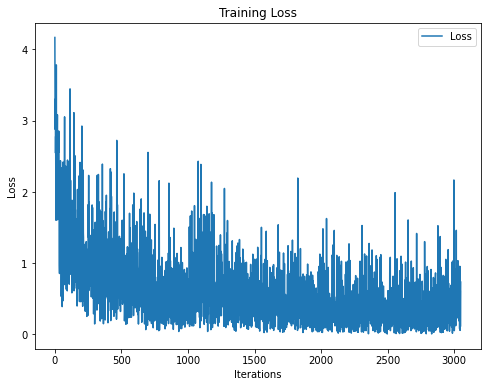

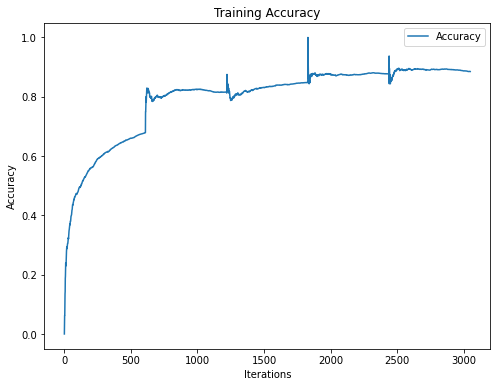

In [8]:
import matplotlib.pyplot as plt

# Loss 그래프
plt.figure(figsize=(8, 6))
plt.plot(trainer.loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 그래프
plt.figure(figsize=(8, 6))
plt.plot(trainer.accuracy_history, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

추세상으로는 학습이 잘 진행되고 있는 것처럼 보인다.

In [9]:
# 모델 테스트 코드

test_ds = load_data(data_path=test_path)

for step_train, (x_batch_train, y_batch_train) in enumerate(test_ds.take(10)):
    prediction = model(x_batch_train)
    print("{}/{}".format(np.array(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1))).sum(), tf.argmax(y_batch_train, axis=1).shape[0]))

26/32
27/32
27/32
29/32
27/32
28/32
29/32
24/32
22/32
29/32


점수가 매우 높다. 즉, 대부분의 이미지를 잘 분류하고 있음.

# 회고
언뜻 생각하기에는 여러 가지 음식이 들어있는 음식보다 동작이 확실히 다른 요가가 더 분류를 잘 할 것 같은데 음식이 훨씬 잘 학습된 게 신기하네요...  
아직은 두 데이터의 차이를 완전히 이해하지는 못했는데 좀 더 찬찬히 살펴봐야 할 것 같습니다.